In [1]:
using LinearAlgebra
using Logging
using PyPlot
using Distributions
using KernelDensity
using StatsBase
using Statistics
using Random
using JLD2
using PyCall

In [2]:
include("../CovarianceFunctions/CovarianceFunctions.jl")


abstract type AbstractPDEs end
struct NonlinElliptic2d{Tα,Tm,TΩ} <: AbstractPDEs
    # eqn: -Δu + α*u^m = f in [Ω[1,1],Ω[2,1]]*[Ω[1,2],Ω[2,2]]
    α::Tα
    m::Tm
    Ω::TΩ
    bdy::Function
    rhs::Function
end

function sample_points_grid(eqn::NonlinElliptic2d, h_in, h_bd)
    Ω = eqn.Ω
    x1l = Ω[1,1]
    x1r = Ω[2,1]
    x2l = Ω[1,2]
    x2r = Ω[2,2]
    x = x1l + h_in:h_in:x1r-h_in
    y = x2l + h_in:h_in:x2r-h_in
    X_domain = reduce(hcat,[[x[i], y[j]] for i in 1:length(x) for j in 1:length(x)])

    l = length(x1l:h_bd:x1r-h_bd)
    X_boundary = vcat([x1l:h_bd:x1r-h_bd x2l*ones(l)], [x1r*ones(l) x2l:h_bd:x2r-h_bd], [x1r:-h_bd:x1l+h_bd x2r*ones(l)], [x1l*ones(l) x2r:-h_bd:x1l+h_bd])
    return X_domain, X_boundary'
end

# assemby Gram matrices
function get_Gram_matrices(eqn::NonlinElliptic2d, cov::AbstractCovarianceFunction, X_domain, X_boundary)
    
    d = 2
    N_domain = size(X_domain,2)
    N_boundary = size(X_boundary,2)

    Δδ_coefs = -1.0

    meas_δ_bd = [PointMeasurement{d}(SVector{d,Float64}(X_boundary[:,i])) for i = 1:N_boundary]
    meas_δ_int = [PointMeasurement{d}(SVector{d,Float64}(X_domain[:,i])) for i = 1:N_domain]
    meas_Δδ = [ΔδPointMeasurement{Float64,d}(SVector{d,Float64}(X_domain[:,i]), Δδ_coefs, 0.0) for i = 1:N_domain]

    measurements = Vector{Vector{<:AbstractPointMeasurement}}(undef,3)
    measurements[1] = meas_δ_bd; measurements[2] = meas_δ_int; measurements[3] = meas_Δδ

    Theta_big = zeros(2*N_domain+N_boundary,2*N_domain+N_boundary)
    cov(Theta_big, reduce(vcat,measurements))
    return Theta_big
end
            
function get_Gram_matrices(eqn::NonlinElliptic2d, cov::AbstractCovarianceFunction, X_domain, X_boundary, sol_now)
    d = 2
    N_domain = size(X_domain,2)
    N_boundary = size(X_boundary,2)
    Δδ_coefs = -1.0
    δ_coefs_int = eqn.α*eqn.m*(sol_now.^(eqn.m-1)) 

    # get linearized PDEs correponding measurements
    meas_δ = [PointMeasurement{d}(SVector{d,Float64}(X_boundary[:,i])) for i = 1:N_boundary]
    meas_Δδ = [ΔδPointMeasurement{Float64,d}(SVector{d,Float64}(X_domain[:,i]), Δδ_coefs, δ_coefs_int[i]) for i = 1:N_domain]
    meas_test_int = [PointMeasurement{d}(SVector{d,Float64}(X_domain[:,i])) for i = 1:N_domain]

    Theta_train = zeros(N_domain+N_boundary,N_domain+N_boundary)

    measurements = Vector{Vector{<:AbstractPointMeasurement}}(undef,2)
    measurements[1] = meas_δ; measurements[2] = meas_Δδ
    cov(Theta_train, reduce(vcat,measurements))
    
    Theta_test = zeros(N_domain,N_domain+N_boundary)

    cov(Theta_test, meas_test_int, reduce(vcat,measurements))
    return Theta_train, Theta_test
end

function  get_initial_covariance(cov::AbstractCovarianceFunction, X_domain, X_boundary)
    d = 2
    N_domain = size(X_domain,2)
    N_boundary = size(X_boundary,2)
    meas_δ_bd = [PointMeasurement{d}(SVector{d,Float64}(X_boundary[:,i])) for i = 1:N_boundary]
    meas_bd_int = [PointMeasurement{d}(SVector{d,Float64}(X_domain[:,i])) for i = 1:N_domain]
    Theta_initial = zeros(N_domain+N_boundary,N_domain+N_boundary)
    measurements = Vector{Vector{<:AbstractPointMeasurement}}(undef,2)
    measurements[1] = meas_δ_bd; measurements[2] = meas_bd_int
    cov(Theta_initial, reduce(vcat,measurements))
    return Theta_initial
end

function  get_initial_covariance(cov::AbstractCovarianceFunction, X_domain)
    d = 2
    N_domain = size(X_domain,2)

    meas_bd_int = [PointMeasurement{d}(SVector{d,Float64}(X_domain[:,i])) for i = 1:N_domain]

    Theta_initial = zeros(N_domain,N_domain)
    cov(Theta_initial, meas_bd_int)
    return Theta_initial
end
                                
# Laplace Approximation
function KalmanLaplaceApprox(eqn, cov, X_domain, X_boundary, sol_init, noise_var_int, noise_var_bd, GNsteps; nugget = 1e-12)
    N_domain = size(X_domain,2)
    N_boundary = size(X_boundary,2)

    # get the rhs and bdy data
    rhs = [eqn.rhs(X_domain[:,i]) for i in 1:N_domain] .+ sqrt(noise_var_int) * randn(N_domain)
    bdy = [eqn.bdy(X_boundary[:,i]) for i in 1:N_boundary] .+ sqrt(noise_var_bd) * randn(N_boundary)
    Theta_train = zeros(N_domain+N_boundary, N_domain+N_boundary) 
    Theta_test = zeros(N_domain,N_domain+N_boundary)

    v = sol_init
    rhs_now = vcat(bdy, rhs.+eqn.α*(eqn.m-1)*v.^eqn.m)
    noise_cov = diagm(vcat([noise_var_bd for _ in 1:N_boundary], [noise_var_int for _ in 1:N_domain]))
    for _ in 1:GNsteps
        Theta_train, Theta_test = get_Gram_matrices(eqn, cov, X_domain, X_boundary, v)
        rhs_now = vcat(bdy, rhs.+eqn.α*(eqn.m-1)*v.^eqn.m)
        v = Theta_test*(((Theta_train+noise_cov+nugget*diagm(diag(Theta_train))))\rhs_now)
    end

    MAP = v
    Cov_init = get_initial_covariance(cov, X_domain) # only consider UQ of domain pts
    Cov_posterior = Cov_init .- Theta_test*(((Theta_train+noise_cov+nugget*diagm(diag(Theta_train))))\Theta_test')
    approx_rkhs_norm2 = rhs_now'* (((Theta_train+noise_cov+nugget*diagm(diag(Theta_train))))\rhs_now)
    return MAP, Cov_posterior, approx_rkhs_norm2
end 


function log_post_GP_PDE(eqn, cov, X_domain, X_boundary; nugget = 1e-14)

    N_domain = size(X_domain,2)
    N_boundary = size(X_boundary,2)

    # get the rhs and bdy data
    rhs = [eqn.rhs(X_domain[:,i]) for i in 1:N_domain] .+ sqrt(noise_var_int) * randn(N_domain)
    bdy = [eqn.bdy(X_boundary[:,i]) for i in 1:N_boundary] .+ sqrt(noise_var_bd) * randn(N_boundary)
    Theta_big = zeros(2*N_domain+N_boundary, 2*N_domain+N_boundary)
    Theta_big = get_Gram_matrices(eqn, cov, X_domain, X_boundary)
    U = cholesky(Theta_big+nugget*diagm(diag(Theta_big))).U  #Theta = U'*U

    function d_log_post(z)
        Z = vcat(bdy,z,rhs.-eqn.α*z.^eqn.m)
        tmp = U\(U'\Z)
        return -0.5*Z'*tmp, -tmp[N_boundary+1:N_boundary+N_domain] + eqn.α*eqn.m*(z.^(eqn.m-1)).*tmp[N_boundary+N_domain+1:end]
    end
    return d_log_post
end


function hessian_log_post_GP_PDE(eqn, cov, X_domain, X_boundary; nugget = 1e-9)
    N_domain = size(X_domain,2)
    N_boundary = size(X_boundary,2)

    # get the rhs and bdy data
    rhs = [eqn.rhs(X_domain[:,i]) for i in 1:N_domain] .+ sqrt(noise_var_int) * randn(N_domain)
    bdy = [eqn.bdy(X_boundary[:,i]) for i in 1:N_boundary] .+ sqrt(noise_var_bd) * randn(N_boundary)
    Theta_big = zeros(2*N_domain+N_boundary, 2*N_domain+N_boundary)
    Theta_big = get_Gram_matrices(eqn, cov, X_domain, X_boundary)
    inv_Theta_big = inv(Theta_big + nugget*diagm(diag(Theta_big)))
    function log_post(z)
        Z = vcat(bdy,z,rhs.-eqn.α*z.^eqn.m)
        return -0.5*Z'*inv_Theta_big*Z
    end
                                                                
    function hessian_log_post(z)
        Z = vcat(bdy,z,rhs.-eqn.α*z.^eqn.m)
        grad_Z = vcat(zeros(N_boundary,N_domain), Matrix(1.0*I,N_domain,N_domain), -eqn.α*eqn.m*diagm(z.^(eqn.m-1)))
        hess = grad_Z'*(Theta_big\grad_Z)
        for i = 1:N_domain
            for j = 1:2*N_domain+N_boundary
                hess[i,i] += inv_Theta_big[N_domain+N_boundary+i, j]*Z[j]*(-eqn.α)*eqn.m*(eqn.m-1)*z[i]^(eqn.m-2)
            end
        end    
        return -hess
    end
#     function hessian_log_post(z)
#         return ReverseDiff.hessian(log_post,z)
#     end
    return log_post, hessian_log_post
end
                                                                       
                                                                

function LaplaceApprox(eqn, cov, X_domain, X_boundary, sol_init, noise_var_int, noise_var_bd, GNsteps; nugget = 1e-14)
    N_domain = size(X_domain,2)
    N_boundary = size(X_boundary,2)

    rhs = [eqn.rhs(X_domain[:,i]) for i in 1:N_domain] .+ sqrt(noise_var_int) * randn(N_domain)
    bdy = [eqn.bdy(X_boundary[:,i]) for i in 1:N_boundary] .+ sqrt(noise_var_bd) * randn(N_boundary)

    Theta_train = zeros(N_domain+N_boundary, N_domain+N_boundary) 
    Theta_test = zeros(N_domain,N_domain+N_boundary)

    v = sol_init
    rhs_now = vcat(bdy, rhs.+eqn.α*(eqn.m-1)*v.^eqn.m)
    noise_cov = diagm(vcat([noise_var_bd for _ in 1:N_boundary], [noise_var_int for _ in 1:N_domain]))
    for _ in 1:GNsteps
        Theta_train, Theta_test = get_Gram_matrices(eqn, cov, X_domain, X_boundary, v)
        rhs_now = vcat(bdy, rhs.+eqn.α*(eqn.m-1)*v.^eqn.m)
        v = Theta_test*(((Theta_train+noise_cov+nugget*diagm(diag(Theta_train))))\rhs_now)
    end

    MAP = v
    _, hessian_log_post = hessian_log_post_GP_PDE(eqn, cov, X_domain, X_boundary)
    hessian_mtx = -hessian_log_post(MAP)
    Cov_posterior = inv(hessian_mtx)
    return MAP, Cov_posterior
end 


α = 10.0
m = 3
Ω = [[0,1] [0,1]]
h_in = 0.1
h_bd = 0.1
lengthscale = 0.3
kernel = "Matern7alf"
cov = MaternCovariance7_2(lengthscale)

function fun_u(x)
    return sin(pi*x[1])*sin(pi*x[2]) + sin(3*pi*x[1])*sin(3*pi*x[2])
end

function fun_rhs(x)
    ans = 2*pi^2*sin(pi*x[1])*sin(pi*x[2]) + 2*(3*pi)^2*sin(3*pi*x[1])*sin(3*pi*x[2])
    return ans + α*fun_u(x)^m 
end

# boundary value
function fun_bdy(x)
    return fun_u(x)
end
eqn = NonlinElliptic2d(α,m,Ω,fun_bdy,fun_rhs)
X_domain, X_boundary = sample_points_grid(eqn, h_in, h_bd)
N_domain = size(X_domain,2)
N_boundary = size(X_boundary,2)
noise_var_int = 0.0
noise_var_bd = 0.0
sol_init = zeros(N_domain) # initial solution
truth = [fun_u(X_domain[:,i]) for i in 1:N_domain]
GNsteps = 10

@time MAP, KalmanLaplace_postvar, rkhs_norm2 = KalmanLaplaceApprox(eqn, cov, X_domain, X_boundary, sol_init, noise_var_int, noise_var_bd, GNsteps)
pts_accuracy = sqrt(sum((truth-MAP).^2)/sum(truth.^2))
@info "[L2 accuracy of MAP to true sol] $pts_accuracy"
pts_max_accuracy = maximum(abs.(truth-MAP))/maximum(abs.(truth))
@info "[Linf accuracy of MAP to true sol] $pts_max_accuracy"
sol_std_Kalman = [sqrt(abs(KalmanLaplace_postvar[i,i])) for i in 1:N_domain]

    
@time MAP_Laplace, Laplace_postvar = LaplaceApprox(eqn, cov, X_domain, X_boundary, sol_init, noise_var_int, noise_var_bd, GNsteps)
sol_std = [sqrt(abs(Laplace_postvar[i,i])) for i in 1:N_domain]

  5.153181 seconds (11.61 M allocations: 610.466 MiB, 4.54% gc time, 98.10% compilation time)
  1.845928 seconds (3.24 M allocations: 179.326 MiB, 2.93% gc time, 94.87% compilation time)


[ Info: [L2 accuracy of MAP to true sol] 0.026602687955986398
[ Info: [Linf accuracy of MAP to true sol] 0.025147907370408673


81-element Vector{Float64}:
 0.02902382940042161
 0.03488683805632843
 0.039543348041128974
 0.04238380238804492
 0.042763748834213834
 0.04238380238806575
 0.039543348041132194
 0.03488683805634833
 0.029023829400439967
 0.034886838056331
 0.04175177173373465
 0.04887228431624442
 0.05368421437744221
 ⋮
 0.04887228431626537
 0.04175177173373074
 0.03488683805633792
 0.02902382940043646
 0.03488683805633569
 0.0395433480411263
 0.04238380238806243
 0.04276374883421394
 0.04238380238806389
 0.039543348041122875
 0.03488683805634395
 0.029023829400432424

In [3]:
tmp = load("MCMC_1e7steps.jld2")
emcee_samples = tmp["sample"]

100001×200×81 Array{Float64, 3}:
[:, :, 1] =
 0.33895   0.37623   1.58941   -0.467886  …  -0.0650587  1.12498   -1.83485
 0.651405  0.650989  0.66435    0.658081      0.656591   0.666916   0.641739
 0.655938  0.698067  0.644945   0.642384      0.662997   0.679631   0.635836
 0.62781   0.667521  0.604482   0.609505      0.641763   0.633138   0.623983
 0.60416   0.603104  0.598887   0.59938       0.610138   0.583398   0.596648
 0.605795  0.593069  0.621373   0.640347  …   0.618136   0.576411   0.6025
 0.637749  0.631684  0.62932    0.635464      0.628605   0.613025   0.654489
 0.656817  0.657229  0.641051   0.638587      0.636303   0.638338   0.664926
 0.65461   0.658331  0.670912   0.660319      0.648012   0.643771   0.667693
 0.674454  0.654895  0.671716   0.689853      0.640934   0.665647   0.660517
 0.667139  0.690935  0.709636   0.675635  …   0.654294   0.675297   0.677963
 0.66263   0.700281  0.71306    0.69148       0.647289   0.716753   0.669895
 0.702091  0.709416  0.71728    0.

In [4]:
mean_emcmc = mean(emcee_samples[10:end,:,:], dims=[1,2])
std_emcmc = std(emcee_samples[10:end,:,:], dims=[1,2])

1×1×81 Array{Float64, 3}:
[:, :, 1] =
 0.029048084915589197

[:, :, 2] =
 0.03493580850863756

[:, :, 3] =
 0.03957383081377133

;;; … 

[:, :, 79] =
 0.03967619719534542

[:, :, 80] =
 0.03500911663257927

[:, :, 81] =
 0.02909296659470747

In [5]:
fsize = 10.0
tsize = 10.0
tdir = "in"
major = 5.0
minor = 3.0
lwidth = 0.8
lhandle = 2.0
plt.style.use("default")
rcParams = PyDict(matplotlib["rcParams"])
rcParams["font.size"] = fsize
rcParams["legend.fontsize"] = tsize
rcParams["xtick.direction"] = tdir
rcParams["ytick.direction"] = tdir
rcParams["xtick.major.size"] = major
rcParams["xtick.minor.size"] = minor
rcParams["ytick.major.size"] = 5.0
rcParams["ytick.minor.size"] = 3.0
rcParams["axes.linewidth"] = lwidth
rcParams["legend.handlelength"] = lhandle

2.0

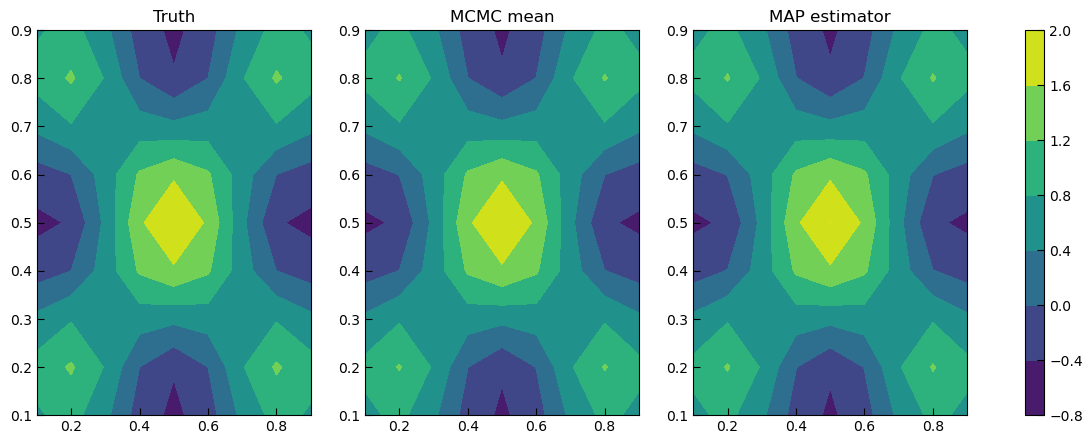

In [8]:
Nh = convert(Int64, 1/h_in-1)
fig, axes = subplots(nrows=1, ncols=3, figsize=(15, 5))
im = axes[1].contourf(reshape(X_domain[1,:],Nh,Nh), reshape(X_domain[2,:],Nh,Nh), reshape(truth[:],Nh,Nh), vmin=-0.8, vmax=2.0)
axes[1].set_title("Truth")
axes[2].contourf(reshape(X_domain[1,:],Nh,Nh), reshape(X_domain[2,:],Nh,Nh), reshape(mean_emcmc[:],Nh,Nh), vmin=-0.8, vmax=2.0)
axes[2].set_title("MCMC mean")
axes[3].contourf(contourf(reshape(X_domain[1,:],Nh,Nh), reshape(X_domain[2,:],Nh,Nh), reshape(MAP,Nh,Nh)), vmin=-0.8, vmax=2.0)
axes[3].set_title("MAP estimator")
fig.colorbar(im, ax=axes)
fig.savefig("gridsize01_mean_comp.pdf", bbox_inches="tight",dpi=100,pad_inches=0.15)


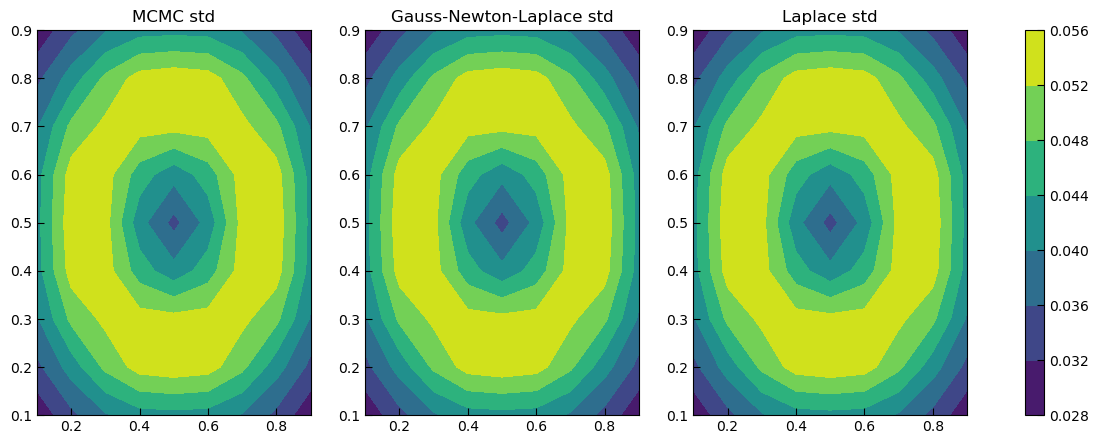

In [9]:
fig2, axes = subplots(nrows=1, ncols=3, figsize=(15, 5))
im2 = axes[1].contourf(reshape(X_domain[1,:],Nh,Nh), reshape(X_domain[2,:],Nh,Nh), reshape(std_emcmc[:],Nh,Nh), vmin=0.028, vmax=0.056)
axes[1].set_title("MCMC std")
axes[2].contourf(reshape(X_domain[1,:],Nh,Nh), reshape(X_domain[2,:],Nh,Nh), reshape(sol_std_Kalman,Nh,Nh), vmin=0.028, vmax=0.056)
axes[2].set_title("Gauss-Newton-Laplace std")
axes[3].contourf(reshape(X_domain[1,:],Nh,Nh), reshape(X_domain[2,:],Nh,Nh), reshape(sol_std,Nh,Nh), vmin=0.028, vmax=0.056)
axes[3].set_title("Laplace std")
fig2.colorbar(im2, ax=axes)
fig2.savefig("gridsize01_std_comp.pdf", bbox_inches="tight",dpi=100,pad_inches=0.15)

# fig_approx = figure(figsize=(15, 5))
# Nh = convert(Int64, 1/h_in-1)
# subplot(131)
# contourf(reshape(X_domain[1,:],Nh,Nh), reshape(X_domain[2,:],Nh,Nh), reshape(std_emcmc[:],Nh,Nh), label = "mcmc-std")
# title("MCMC std")
# colorbar()
# subplot(132)
# contourf(reshape(X_domain[1,:],Nh,Nh), reshape(X_domain[2,:],Nh,Nh), reshape(sol_std_Kalman,Nh,Nh))
# title("Gauss-Newton-Laplace std")
# colorbar()
# subplot(133)
# contourf(reshape(X_domain[1,:],Nh,Nh), reshape(X_domain[2,:],Nh,Nh), reshape(sol_std,Nh,Nh))
# title("Laplace std")
# colorbar()

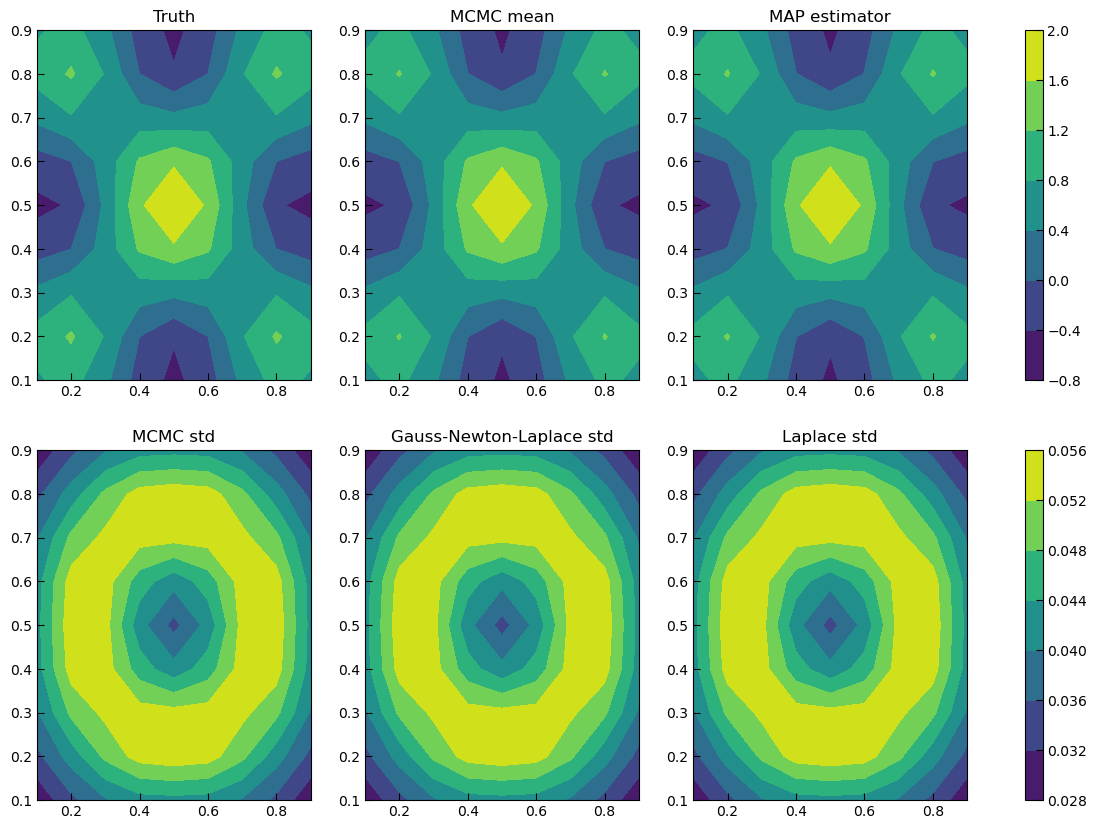

In [14]:
Nh = convert(Int64, 1/h_in-1)
fig, axes = subplots(nrows=2, ncols=3, figsize=(15, 10))
im = axes[1,1].contourf(reshape(X_domain[1,:],Nh,Nh), reshape(X_domain[2,:],Nh,Nh), reshape(truth[:],Nh,Nh), vmin=-0.8, vmax=2.0)
axes[1,1].set_title("Truth")
axes[1,2].contourf(reshape(X_domain[1,:],Nh,Nh), reshape(X_domain[2,:],Nh,Nh), reshape(mean_emcmc[:],Nh,Nh), vmin=-0.8, vmax=2.0)
axes[1,2].set_title("MCMC mean")
axes[1,3].contourf(contourf(reshape(X_domain[1,:],Nh,Nh), reshape(X_domain[2,:],Nh,Nh), reshape(MAP,Nh,Nh)), vmin=-0.8, vmax=2.0)
axes[1,3].set_title("MAP estimator")
fig.colorbar(im, ax=axes[1,1:3])

im2 = axes[2,1].contourf(reshape(X_domain[1,:],Nh,Nh), reshape(X_domain[2,:],Nh,Nh), reshape(std_emcmc[:],Nh,Nh), vmin=0.028, vmax=0.056)
axes[2,1].set_title("MCMC std")
axes[2,2].contourf(reshape(X_domain[1,:],Nh,Nh), reshape(X_domain[2,:],Nh,Nh), reshape(sol_std_Kalman,Nh,Nh), vmin=0.028, vmax=0.056)
axes[2,2].set_title("Gauss-Newton-Laplace std")
axes[2,3].contourf(reshape(X_domain[1,:],Nh,Nh), reshape(X_domain[2,:],Nh,Nh), reshape(sol_std,Nh,Nh), vmin=0.028, vmax=0.056)
axes[2,3].set_title("Laplace std")
fig2.colorbar(im2, ax=axes[2,1:3])

# fig.savefig("gridsize01_meanstd_comp.pdf", bbox_inches="tight",dpi=100,pad_inches=0.15)


PyObject <AxesSubplot:title={'center':'Truth'}>

In [8]:
# fig1 = figure(figsize=(15, 5))
# Nh = convert(Int64, 1/h_in-1)

# subplot(131)
# contourf(reshape(X_domain[1,:],Nh,Nh), reshape(X_domain[2,:],Nh,Nh), reshape(truth[:],Nh,Nh), label = "truth")
# title("Truth")
# colorbar()
# subplot(132)
# contourf(reshape(X_domain[1,:],Nh,Nh), reshape(X_domain[2,:],Nh,Nh), reshape(mean_emcmc[:],Nh,Nh), label = "mcmc-mean")
# title("MCMC mean")
# colorbar()
# subplot(133)
# contourf(reshape(X_domain[1,:],Nh,Nh), reshape(X_domain[2,:],Nh,Nh), reshape(MAP,Nh,Nh), label = "MAP")
# title("MAP estimator")
# colorbar()
# fig1.savefig("gridsize01_mean_comp.pdf", bbox_inches="tight",dpi=100,pad_inches=0.15)

# fig_approx = figure(figsize=(15, 5))
# Nh = convert(Int64, 1/h_in-1)
# subplot(131)
# contourf(reshape(X_domain[1,:],Nh,Nh), reshape(X_domain[2,:],Nh,Nh), reshape(std_emcmc[:],Nh,Nh), label = "mcmc-std")
# title("MCMC std")
# colorbar()
# subplot(132)
# contourf(reshape(X_domain[1,:],Nh,Nh), reshape(X_domain[2,:],Nh,Nh), reshape(sol_std_Kalman,Nh,Nh))
# title("Gauss-Newton-Laplace std")
# colorbar()
# subplot(133)
# contourf(reshape(X_domain[1,:],Nh,Nh), reshape(X_domain[2,:],Nh,Nh), reshape(sol_std,Nh,Nh))
# title("Laplace std")
# colorbar()
# fig_approx.savefig("gridsize01_std_comp.pdf", bbox_inches="tight",dpi=100,pad_inches=0.15)

# # legend()

# # fig = figure(figsize=(10, 5))
# # subplot(121)
# # contourf(reshape(X_domain[1,:],Nh,Nh), reshape(X_domain[2,:],Nh,Nh), reshape(abs.(truth[:] - MAP[:]),Nh,Nh))
# # title("Error of MAP")
# # colorbar()
# # subplot(122)
# # contourf(reshape(X_domain[1,:],Nh,Nh), reshape(X_domain[2,:],Nh,Nh), reshape(abs.(truth[:] - mean_emcmc[:]),Nh,Nh))
# # title("Error of MCMC mean")
# # colorbar()

In [19]:

print("Laplace mean err ", sqrt.(mean(abs.(mean_emcmc[:] - MAP).^2)) ./ sqrt.(mean(abs.(mean_emcmc[:]).^2)))
print("\n Laplace std err ", sqrt.(mean(abs.(std_emcmc[:] - sol_std).^2)) ./ sqrt.(mean(std_emcmc[:].^2)))
print("\n Kalman std err ", sqrt.(mean(abs.(std_emcmc[:] - sol_std_Kalman).^2)) ./ sqrt.(mean(std_emcmc[:].^2)))


Laplace mean err 0.006320173025899397
 Laplace std err 0.0021363969685871515
 Kalman std err 0.004086645359937782

In [10]:
sqrt(rkhs_norm2)

12.796990762874549

In [11]:
maximum(abs.(mean_emcmc[:] - truth[:]))/maximum(abs.(truth))

0.02582830258439589

In [12]:
sqrt(sum((mean_emcmc[:] - truth[:]).^2)/sum(truth.^2))

0.026664928805807578

In [11]:
emcee_samples[10^4:end,:,:]

90002×200×81 Array{Float64, 3}:
[:, :, 1] =
 0.675245  0.701534  0.746782  0.711788  …  0.715654  0.711469  0.650427
 0.669869  0.697702  0.758452  0.741632     0.73975   0.70103   0.635637
 0.686891  0.700038  0.748728  0.738609     0.724952  0.703616  0.644703
 0.676806  0.685141  0.744903  0.73232      0.729837  0.703836  0.633986
 0.679777  0.690066  0.756208  0.768389     0.737697  0.691225  0.64212
 0.672709  0.692128  0.7533    0.763621  …  0.744352  0.689941  0.648502
 0.685952  0.703418  0.753508  0.786087     0.742971  0.7085    0.650852
 0.680484  0.692539  0.742943  0.774233     0.7397    0.703246  0.621363
 0.661878  0.692643  0.750541  0.788376     0.726747  0.73403   0.622119
 0.658353  0.688852  0.760792  0.775899     0.716591  0.739955  0.630668
 0.661107  0.694762  0.746687  0.793386  …  0.709441  0.748935  0.623612
 0.670995  0.701265  0.750768  0.765987     0.704183  0.738595  0.636916
 0.670299  0.695094  0.736882  0.77388      0.680202  0.716849  0.611014
 ⋮      

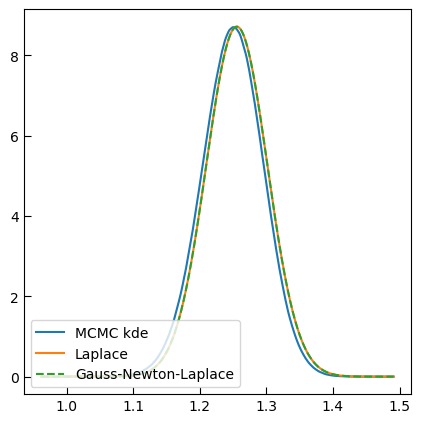

In [43]:
fig = figure(figsize=(5, 5))

idx = 81÷2-9
emcee_ite = size(emcee_samples)[1]
kde_data = reshape(emcee_samples[emcee_ite÷2:end,:,idx], prod(size(emcee_samples[emcee_ite÷2:end,:,idx])))
emcee_density_mcmc = kde(kde_data)
plot(emcee_density_mcmc.x,emcee_density_mcmc.density, label = "MCMC kde")

gmean = MAP[idx]
gstd = sol_std[idx]
x = emcee_density_mcmc.x
density_gaussian_y = 1/(sqrt(2*pi)*gstd)*exp.(-(x.-gmean).^2/(2*gstd^2))
plot(x, density_gaussian_y, label = "Laplace")

gmean2 = mean_emcmc[idx]
gstd2 = sol_std_Kalman[idx]
density_kalmangaussian_y = 1/(sqrt(2*pi)*gstd2)*exp.(-(x.-gmean2).^2/(2*gstd2^2))
plot(x, density_gaussian_y, "--", label = "Gauss-Newton-Laplace")
legend(loc="lower left")

fig.savefig("kde_gridsize01.pdf", bbox_inches="tight",dpi=100,pad_inches=0.15)


31-element Vector{Float64}:
  0.744484768808729
  0.7579353171925615
  0.4807229725003237
 -0.1700054689945759
  0.0062510370337342915
  0.5904589766769617
  1.248912414738971
  1.5366935291650408
  1.2488670648801414
  0.5903525184667703
  0.006053146983573792
 -0.1701454086324561
 -0.4745119300801567
  ⋮
 -0.34954342009728867
 -0.47466304014830435
 -0.17010384801664266
  0.006079392473339881
  0.5903474301629382
  1.2488654637391265
  1.5365659675238459
  1.2487523733256969
  0.5903379220514311
  0.006058605821529028
 -0.1701677542903402
  0.4807361643683557

In [41]:
fun_u([0.6,0.4])

1.25